# Radial Velocity Method 

We will first use NEID data to understand the principle.

In [2]:
pip install radvel

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install celerite

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install _curses

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '_curses'


In [5]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import copy
from astropy.io import fits
import radvel # for diff orbital velocities 

ModuleNotFoundError: No module named '_curses'

In [6]:
# Load one NEID solar spectrum
# Based on https://github.com/arpita308/NEID_Tutorials
# https://neid.ipac.caltech.edu/search_solar.php
hdul = fits.open('neidL2_20210208T191024.fits') # ut time 
hdul.info() #neid spectrograph (shows summary of fits file: 14 extensions : primary contrains headers with no data  

FileNotFoundError: [Errno 2] No such file or directory: 'neidL2_20220203T203635.fits'

h-shell grating= large orders (higher deivation for higher orders).
9216 pixels in one axis and 122 lines(orderrs). each order gives different wavelength.
3 fibres towards= star, sky and wavelength caliberation lamp. 
var=error in readings 
wave= wavelengths stored as array 

<IPython.core.display.Javascript object>


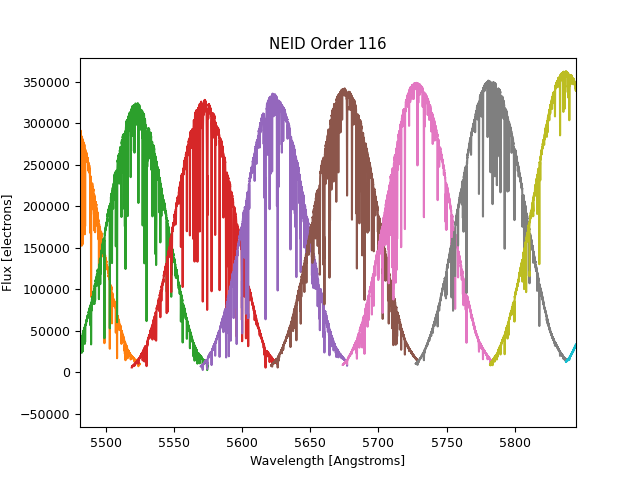

In [18]:
# Plot the spectrum. solar spectrum, not really a gaussian, size driven by grating at that order   
%matplotlib notebook
for order in range(10,117):
  plt.plot(hdul['SCIWAVE'].data[order],hdul['SCIFLUX'].data[order])
plt.title('NEID Order {}'.format(order))
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [electrons]')
plt.show()
#overall spectrum, shape due to sun and ccd sensitivit y
#H-alpha line around 6500 angstrom 

<IPython.core.display.Javascript object>


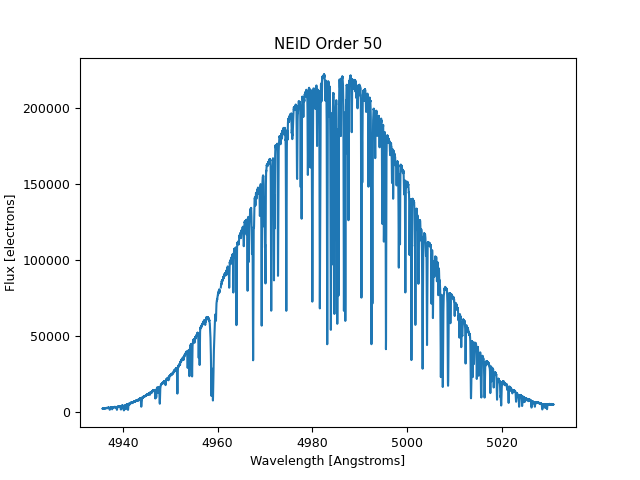

In [20]:
# Plot the spectrum. solar spectrum, not really a gaussian, size driven by grating at that order   
%matplotlib notebook
order=50
plt.plot(hdul['SCIWAVE'].data[order],hdul['SCIFLUX'].data[order])
plt.title('NEID Order {}'.format(order))
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [electrons]')
plt.show()
#overall spectrum, shape due to sun and ccd sensitivit y
#H-alpha line around 6500 angstrom 

In [24]:
# Artifically doppler shift the spectrum, the wavelength gets shifted by 1+v/c
from scipy import interpolate
from scipy.constants import speed_of_light
dopplerfactor = 1 + 1./speed_of_light  # 1m/s= star velocity 
gm = np.isfinite(hdul['SCIFLUX'].data[order]) #to remove nan values form data array (good pixel mass)
#np.isfinite= gives finite values (sets infinite value false)
shifted_spectrum = interpolate.interp1d(hdul['SCIWAVE'].data[order][gm]*dopplerfactor, 
                         hdul['SCIFLUX'].data[order][gm],kind="cubic",fill_value="extrapolate")(hdul['SCIWAVE'].data[order])
#only taking useful data 
#doppler shifting the spectrum and interpolating back to the original grid to compare 

In [25]:
dopplerfactor

1.0000000033356409

<IPython.core.display.Javascript object>


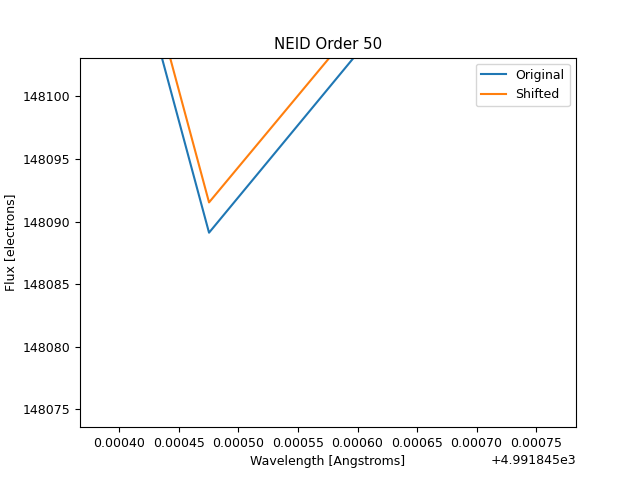

In [27]:
#Plot and compare
plt.plot(hdul['SCIWAVE'].data[order],hdul['SCIFLUX'].data[order],label="Original")
plt.plot(hdul['SCIWAVE'].data[order],shifted_spectrum,label="Shifted")
plt.title('NEID Order {}'.format(order))
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [electrons]')
plt.legend()
plt.show()
#almoost overlapping 

<IPython.core.display.Javascript object>


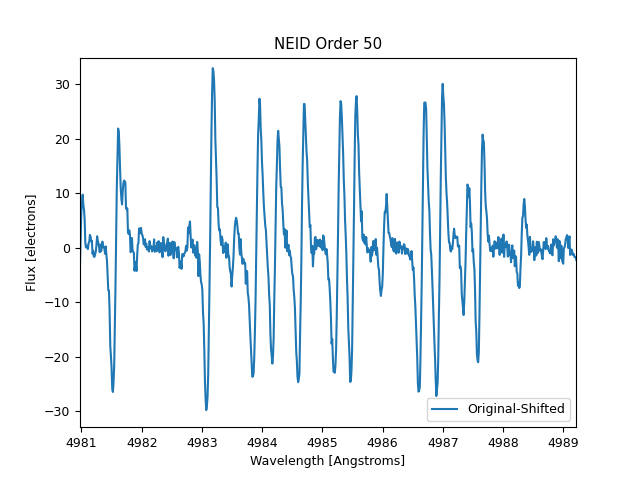

In [28]:
# Plot the difference between original and shifted 
plt.plot(hdul['SCIWAVE'].data[order],hdul['SCIFLUX'].data[order]-shifted_spectrum,label="Original-Shifted")
plt.title('NEID Order {}'.format(order))
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [electrons]')
plt.legend()
plt.show()
#the change in flux in both 

<IPython.core.display.Javascript object>


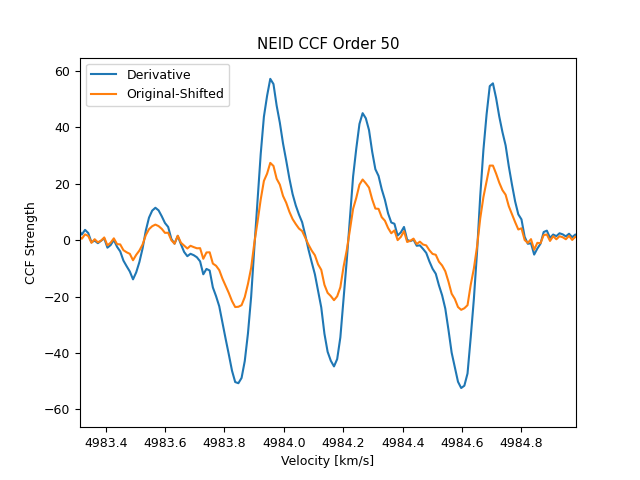

In [36]:
# Compare to Derivative
plt.plot(hdul['SCIWAVE'].data[order],np.gradient(hdul['SCIFLUX'].data[order])/300.,label="Derivative")
plt.plot(hdul['SCIWAVE'].data[order],hdul['SCIFLUX'].data[order]-shifted_spectrum,label="Original-Shifted")
plt.title('NEID Order {}'.format(order))
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [electrons]')
plt.legend()
plt.show()
#blue is a derivatve 
#the scale of blue depends on how we havew defined gradient
#info of line centre is on the slope of the curve at sides and not the peak 
#this method works for blended lines too, we dont have to fir gaussian for each line
#gives the relative change of velocity from one epoch to another, does not tell absolute velocity of the star 
#to check whether or not the gaussian is shifted we see the movement of the width and not peak 
#resolution=delta(lambda)/lamda

# Theoretical limit to measurable velocity precision
https://ui.adsabs.harvard.edu/abs/2001A&A...374..733B/abstract

# CCF
https://neid.ipac.caltech.edu/docs/NEID-DRP/_images/ccf_fitting.png

In [37]:
hdul['CCFS'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  804                                                  
NAXIS2  =                  122                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
CTYPE1  = 'km/s    '           / Pixel coordinate system in x                   
CTYPE2  = 'e-      '           / Pixel coordinate system in y                   
CCFSTART=               -100.0 / Start of RV range (km/s)                       
CCFSTEP =                 0.25 / Step of RV range (km/s)                        
MAXCPP  =    5010849.664593624 / Max count/pixel of CCF)                        
CCFLINES=                 55

In [38]:
# Nicely formatted print statements
print('Radial velocity of this observation is {} km/s.'.format(hdul['CCFS'].header['CCFRVMOD']))
print('Time of this observation is {} BJD.'.format(hdul['CCFS'].header['CCFJDMOD']))

Radial velocity of this observation is -0.6403652439391726 km/s.
Time of this observation is 2459254.294322899 BJD.


In [41]:
# These are the header keywords we will need to plot the CCF
ccfstart = float(hdul['CCFS'].header['CCFSTART'])
ccfstep = float(hdul['CCFS'].header['CCFSTEP'])
npixels = float(hdul['CCFS'].header['NAXIS1'])
gamma_rv = float(hdul[0].header['QRV'])

print('Start of x-axis velocity array:',ccfstart)
print('Step size of x-axis velocity array:',ccfstep)
print('Length of x-axis velocity array:',npixels)
print('Rough average velocity of star:',gamma_rv)  # --> Will be 0 for the Sun

Start of x-axis velocity array: -100.0
Step size of x-axis velocity array: 0.25
Length of x-axis velocity array: 804.0
Rough average velocity of star: 0.0


<IPython.core.display.Javascript object>


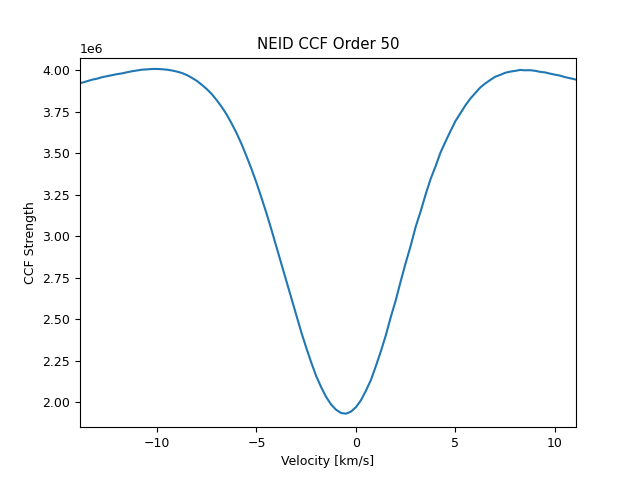

In [43]:
velocity_loop = (np.arange(npixels)*ccfstep) + ccfstart + gamma_rv
plt.plot(velocity_loop,hdul['CCFS'].data[order])
plt.title('NEID CCF Order {}'.format(order))
plt.xlabel('Velocity [km/s]')
plt.ylabel('CCF Strength')
plt.show()

# Keplerian Model fitting to Radial velocity data

In [44]:
# Based on https://github.com/California-Planet-Search/radvel/blob/master/docs/tutorials/SyntheticData.ipynb
# Intialize Keplerian model parameters
params = radvel.Parameters(1,basis='per tc secosw sesinw k')
params['k1'] = radvel.Parameter(value=1)
params['per1'] = radvel.Parameter(value=1)
params['secosw1'] = radvel.Parameter(value=0.6)
params['sesinw1'] = radvel.Parameter(value=+0.2)
params['tc1'] = radvel.Parameter(value=0.)
rv_mod = radvel.RVModel(params)
#need parameters to define an orbit

In [46]:
# Generate Synthetic Data
t = np.random.random_sample(40)
t = t * 4 - 2
t = np.sort(t)
ti = np.linspace(-2,2,400)
errvel = 0.3
jitter = 0.3
syn_rv = rv_mod(t) + np.random.random(t.size)*np.sqrt(errvel**2 + jitter**2) #adding noise on that model to make it look real

<IPython.core.display.Javascript object>


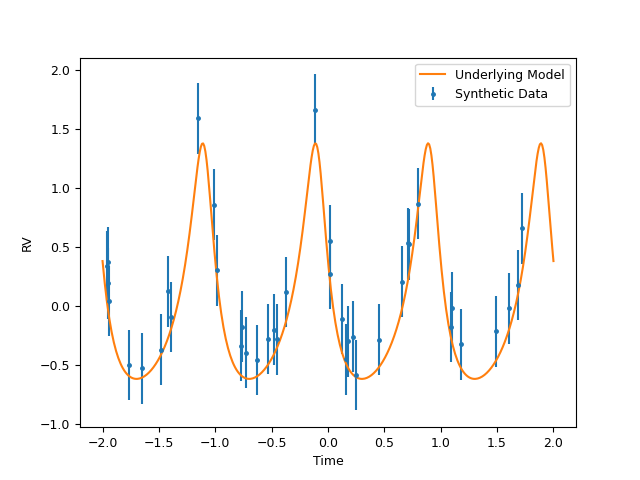

In [48]:
# Plot the Synthetic Data
plt.errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plt.plot(ti,rv_mod(ti),label='Underlying Model')
plt.xlabel('Time')
plt.ylabel('RV')
plt.legend()
plt.show() # not clean sin shape

In [76]:
# Generate a likelihood
like_syn = radvel.likelihood.RVLikelihood(rv_mod,t,syn_rv,np.zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=errvel)

truths = copy.deepcopy(like_syn.params) # Store away model parameters for later reference
like_syn.params.update(dict(k1=radvel.Parameter(value=3),
                            secosw1=radvel.Parameter(value=0.1),
                            sesinw1=radvel.Parameter(value=0.1),
                            tc1=radvel.Parameter(value=0.1))) # perturb the starting guess

like_syn.params['jit'].vary = False # Don't vary jitter


In [77]:
#Perform a maximum likelihood fit
print('Starting Guess:',like_syn.get_vary_params())
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B' )
print(res)
print(like_syn)

Starting Guess: [1.  0.1 0.1 0.1 3.  0.  0.3]
 final_simplex: (array([[ 9.82277679e-01, -9.30670752e-04,  5.97874380e-01,
         4.14776467e-02,  8.79615053e-01, -1.14426824e-03,
        -3.46601783e-03],
       [ 9.82277432e-01, -9.29176072e-04,  5.97863845e-01,
         4.14067160e-02,  8.79543420e-01, -1.14077772e-03,
        -3.45722069e-03],
       [ 9.82275504e-01, -9.32584539e-04,  5.97883536e-01,
         4.13902527e-02,  8.79587403e-01, -1.14025620e-03,
        -3.47375016e-03],
       [ 9.82277984e-01, -9.32480804e-04,  5.97869814e-01,
         4.14306439e-02,  8.79588402e-01, -1.14177041e-03,
        -3.47619024e-03],
       [ 9.82275736e-01, -9.27183151e-04,  5.97861420e-01,
         4.15042906e-02,  8.79557970e-01, -1.14540829e-03,
        -3.45186916e-03],
       [ 9.82276914e-01, -9.30577805e-04,  5.97874817e-01,
         4.14018894e-02,  8.79543508e-01, -1.14030093e-03,
        -3.50200615e-03],
       [ 9.82280037e-01, -9.24049656e-04,  5.97865035e-01,
         4.142

<IPython.core.display.Javascript object>


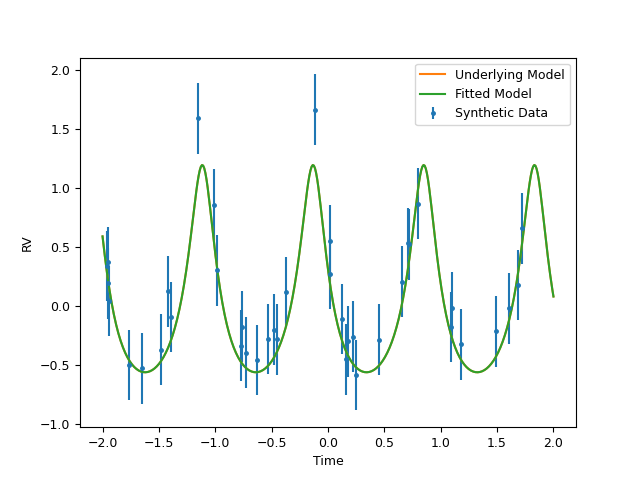

In [78]:
plt.errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plt.plot(ti,rv_mod(ti),label='Underlying Model')
plt.plot(ti,like_syn.model(ti),label='Fitted Model')
plt.xlabel('Time')
plt.ylabel('RV')
plt.legend()
plt.show()

In [79]:
# Instantiate a posterior object
post = radvel.posterior.Posterior(like_syn)
post.params['per1'] = radvel.Parameter(value=1)
post.params['k1'] = radvel.Parameter(value=1)
post.params['jit'].vary = True
post.priors += [radvel.prior.EccentricityPrior( 1 )]
post.priors += [radvel.prior.Gaussian( 'jit', errvel, 0.1)]
post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]
post.priors += [radvel.prior.Gaussian( 'tc1', 0, 0.1)]

post.priors += [radvel.prior.SecondaryEclipsePrior(1, 0.5, 0.01)]

print(post)

parameter                     value      vary
per1                              1       True
tc1                             0.1       True
secosw1                         0.1       True
sesinw1                         0.1       True
k1                                3       True
gamma                             0       True
jit                             0.3       True
tp1                      -0.0205459           
e1                             0.02           
w1                         0.785398           

Priors
------
e1 constrained to be < 0.99
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1
Gaussian prior on tc1, mu=0, sigma=0.1
secondary eclipse constraint: 0.5 +/- 0.01



In [80]:
# Perform maximum likelihood fit on posterior
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )

<IPython.core.display.Javascript object>


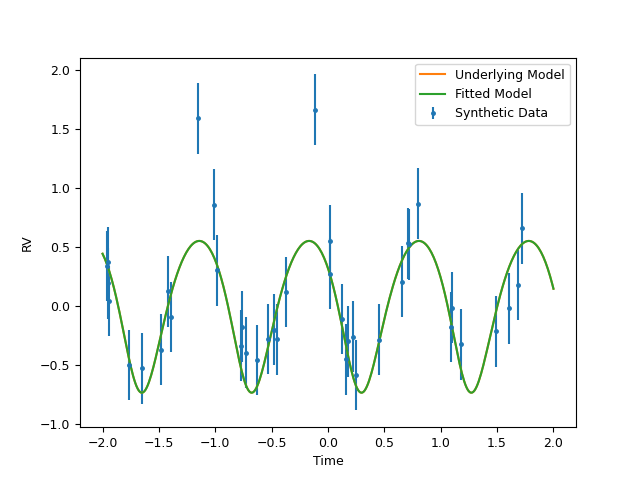

In [81]:
plt.errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plt.plot(ti,rv_mod(ti),label='Underlying Model')
plt.plot(ti,post.likelihood.model(ti),label='Fitted Model')
plt.xlabel('Time')
plt.ylabel('RV')
plt.legend()
plt.show()

In [82]:
#Use mcmc to sample the posterior distribution
df = radvel.mcmc(post,nwalkers=20,nrun=1000)#,savename='rawchain.h5')

AttributeError: module 'numpy.__config__' has no attribute 'blas_opt_info'

In [ ]:
# Plot the corner plot
import corner
labels = [k for k in post.params.keys() if post.params[k].vary]



fig = corner.corner(
            df[labels],
            labels=labels,
            truths=[truths[k].value for k in labels ],
            quantiles=[0.15,0.85],
            plot_datapoints=False,
            smooth=True,
            bins=20
            )